In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader  
from skimage import io

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Experiment 3

In [4]:
!unzip "/content/Dataset_2.zip"

Archive:  /content/Dataset_2.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/Dataset_2.zip or
        /content/Dataset_2.zip.zip, and cannot find /content/Dataset_2.zip.ZIP, period.


In [6]:
train_csv2  = pd.read_csv('/content/verification_train.csv')
test_csv2 = pd.read_csv('/content/verification_test.csv')

In [7]:
import numpy as np
class second_Dataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.data_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.data_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [8]:
train_set = second_Dataset(train_csv2, transform=transforms.Compose([transforms.ToTensor()]))
test_set = second_Dataset(test_csv2, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(train_set, batch_size=100)

For experiment 1

In [9]:
print(len(train_set))
print(len(test_set))

60000
10000


In [10]:
# Hyperparameters

batch_size = 20
num_iters = 20000
input_dim = 28*28 # num_features = 784
num_hidden = 200 # num of hidden nodes
output_dim = 10

learning_rate = 0.01  # More power so we can learn faster! previously it was 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




'''
MAKING DATASET ITERABLE
'''
num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=batch_size, 
                                          shuffle=False)





class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_3 = nn.ReLU()

        ### 4th hidden layer: 100 --> 100
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_4 = nn.ReLU()

        ### 5th hidden layer: 100 --> 100
        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_5 = nn.ReLU()

        ### 6th hidden layer: 100 --> 100
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_6 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
        
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 1st hidden layer
        out = self.relu_3(out)
        
        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_4(out)

        ### 5th hidden layer
        out  = self.linear_5(out)
        ### Non-linearity in 1st hidden layer
        out = self.relu_5(out)
        
        ### 6th hidden layer
        out  = self.linear_6(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_6(out)
     
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas


# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
iteration_loss= []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.6439918279647827. Accuracy: 78.45
Iteration: 1000. Loss: 0.26295363903045654. Accuracy: 81.39
Iteration: 1500. Loss: 0.8555036783218384. Accuracy: 81.07
Iteration: 2000. Loss: 0.29444608092308044. Accuracy: 83.63
Iteration: 2500. Loss: 0.22991855442523956. Accuracy: 85.18
Iteration: 3000. Loss: 0.33452069759368896. Accuracy: 84.77
Iteration: 3500. Loss: 0.39781031012535095. Accuracy: 83.72
Iteration: 4000. Loss: 0.4153572916984558. Accuracy: 85.13
Iteration: 4500. Loss: 0.04165446013212204. Accuracy: 86.42
Iteration: 5000. Loss: 0.47710639238357544. Accuracy: 83.11
Iteration: 5500. Loss: 0.22582519054412842. Accuracy: 85.89
Iteration: 6000. Loss: 0.22875995934009552. Accuracy: 84.78
Iteration: 6500. Loss: 0.4039989113807678. Accuracy: 85.37
Iteration: 7000. Loss: 0.546369194984436. Accuracy: 86.98
Iteration: 7500. Loss: 0.6979178190231323. Accuracy: 86.74
Iteration: 8000. Loss: 0.1925526261329651. Accuracy: 86.52
Iteration: 8500. Loss: 0.3779537081718445. Accura

[0.6439918279647827, 0.26295363903045654, 0.8555036783218384, 0.29444608092308044, 0.22991855442523956, 0.33452069759368896, 0.39781031012535095, 0.4153572916984558, 0.04165446013212204, 0.47710639238357544, 0.22582519054412842, 0.22875995934009552, 0.4039989113807678, 0.546369194984436, 0.6979178190231323, 0.1925526261329651, 0.3779537081718445, 0.09374136477708817, 0.3033270239830017, 0.4801381230354309, 0.4328751564025879, 0.2919697165489197, 0.6562609076499939, 0.20890744030475616, 0.22931678593158722, 0.12189160287380219, 0.46282273530960083, 0.3808688521385193, 0.08998873084783554, 0.06176230311393738, 0.16529029607772827, 0.36952465772628784, 0.10613854229450226, 0.23567378520965576, 0.33878257870674133, 0.4110471308231354]


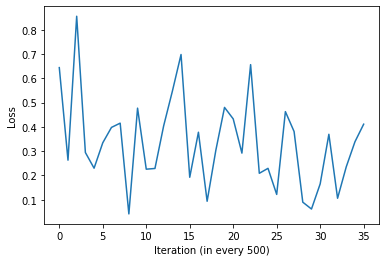

In [11]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

For experiment 2

In [12]:
# Hyperparameters

batch_size = 100
num_iters = 50000
input_dim = 28*28 # num_features = 784
num_hidden = 1000 # num of hidden nodes
output_dim = 10

learning_rate = 0.01  # More power so we can learn faster! previously it was 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


'''
MAKING DATASET ITERABLE
'''
num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        ### 4th hidden layer: 100 --> 100
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.relu_4 = nn.ReLU()

        ### 5th hidden layer: 100 --> 100
        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 5th hidden layer
        self.relu_5 = nn.ReLU()

        ### 6th hidden layer: 100 --> 100
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 6th hidden layer
        self.relu_6 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
        
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 1st hidden layer
        out = self.relu_3(out)

         ### 4rd hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 1st hidden layer
        out = self.relu_4(out)

      ### 5rd hidden layer
        out  = self.linear_5(out)
        ### Non-linearity in 1st hidden layer
        out = self.relu_5(out)

      ### 6rd hidden layer
        out  = self.linear_6(out)
        ### Non-linearity in 1st hidden layer
        out = self.relu_6(out)
      
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas


# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


Iteration: 500. Loss: 0.34750598669052124. Accuracy: 85.72
Iteration: 1000. Loss: 0.30532750487327576. Accuracy: 86.34
Iteration: 1500. Loss: 0.4223014712333679. Accuracy: 87.42
Iteration: 2000. Loss: 0.3694678843021393. Accuracy: 86.64
Iteration: 2500. Loss: 0.2725166082382202. Accuracy: 88.32
Iteration: 3000. Loss: 0.2745942175388336. Accuracy: 88.29
Iteration: 3500. Loss: 0.2624613642692566. Accuracy: 87.92
Iteration: 4000. Loss: 0.21653617918491364. Accuracy: 88.81
Iteration: 4500. Loss: 0.24547596275806427. Accuracy: 87.78
Iteration: 5000. Loss: 0.15418210625648499. Accuracy: 88.09
Iteration: 5500. Loss: 0.17795106768608093. Accuracy: 88.58
Iteration: 6000. Loss: 0.10858937352895737. Accuracy: 89.6
Iteration: 6500. Loss: 0.2467653602361679. Accuracy: 89.85
Iteration: 7000. Loss: 0.1825697124004364. Accuracy: 89.16
Iteration: 7500. Loss: 0.19942346215248108. Accuracy: 88.99
Iteration: 8000. Loss: 0.24598319828510284. Accuracy: 89.24
Iteration: 8500. Loss: 0.08067880570888519. Accur

[0.34750598669052124, 0.30532750487327576, 0.4223014712333679, 0.3694678843021393, 0.2725166082382202, 0.2745942175388336, 0.2624613642692566, 0.21653617918491364, 0.24547596275806427, 0.15418210625648499, 0.17795106768608093, 0.10858937352895737, 0.2467653602361679, 0.1825697124004364, 0.19942346215248108, 0.24598319828510284, 0.08067880570888519, 0.13090316951274872, 0.21754617989063263, 0.12709450721740723, 0.12718172371387482, 0.11052016168832779, 0.1649623066186905, 0.11514009535312653, 0.17140613496303558, 0.09933438897132874, 0.11575232446193695, 0.03389452397823334, 0.04055175930261612, 0.09710628539323807, 0.0965333953499794, 0.10127832740545273, 0.12038102746009827, 0.05613476783037186, 0.14491704106330872, 0.052994947880506516, 0.07021801173686981, 0.06097457557916641, 0.07543535530567169, 0.044714003801345825, 0.023624522611498833, 0.0495610386133194, 0.013417934067547321, 0.06257704645395279, 0.015317516401410103, 0.027066407725214958, 0.05823924392461777, 0.05944001302123

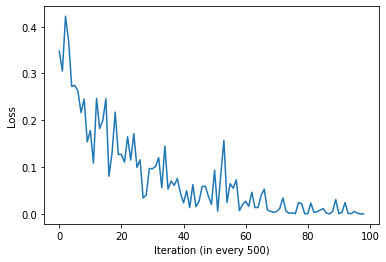

In [13]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()